<a href="https://colab.research.google.com/github/gitnicolas343/sistemas-computacionales-inteligentes/blob/main/Taller_Incertidumbre_Knowledge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller de Incertidumbre y Agentes basados en Conocimiento

In [ ]:
#ejercicio 1
!pip install pomegranate==1.1.1 --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 10.0 MB/s eta 0:00:00


In [ ]:
from pomegranate.distributions import Categorical, ConditionalCategorical
from pomegranate.bayesian_network import *
from torch.masked import MaskedTensor
from collections import Counter
import numpy as np


In [ ]:
#modulo de logica


import itertools


class Sentence():

    def evaluate(self, model):
        """Evaluates the logical sentence."""
        raise Exception("nothing to evaluate")

    def formula(self):
        """Returns string formula representing logical sentence."""
        return ""

    def symbols(self):
        """Returns a set of all symbols in the logical sentence."""
        return set()

    @classmethod
    def validate(cls, sentence):
        if not isinstance(sentence, Sentence):
            raise TypeError("must be a logical sentence")

    @classmethod
    def parenthesize(cls, s):
        """Parenthesizes an expression if not already parenthesized."""
        def balanced(s):
            """Checks if a string has balanced parentheses."""
            count = 0
            for c in s:
                if c == "(":
                    count += 1
                elif c == ")":
                    if count <= 0:
                        return False
                    count -= 1
            return count == 0
        if not len(s) or s.isalpha() or (
            s[0] == "(" and s[-1] == ")" and balanced(s[1:-1])
        ):
            return s
        else:
            return f"({s})"


class Symbol(Sentence):

    def __init__(self, name):
        self.name = name

    def __eq__(self, other):
        return isinstance(other, Symbol) and self.name == other.name

    def __hash__(self):
        return hash(("symbol", self.name))

    def __repr__(self):
        return self.name

    def evaluate(self, model):
        try:
            return bool(model[self.name])
        except KeyError:
            raise EvaluationException(f"variable {self.name} not in model")

    def formula(self):
        return self.name

    def symbols(self):
        return {self.name}


class Not(Sentence):
    def __init__(self, operand):
        Sentence.validate(operand)
        self.operand = operand

    def __eq__(self, other):
        return isinstance(other, Not) and self.operand == other.operand

    def __hash__(self):
        return hash(("not", hash(self.operand)))

    def __repr__(self):
        return f"Not({self.operand})"

    def evaluate(self, model):
        return not self.operand.evaluate(model)

    def formula(self):
        return "¬" + Sentence.parenthesize(self.operand.formula())

    def symbols(self):
        return self.operand.symbols()


class And(Sentence):
    def __init__(self, *conjuncts):
        for conjunct in conjuncts:
            Sentence.validate(conjunct)
        self.conjuncts = list(conjuncts)

    def __eq__(self, other):
        return isinstance(other, And) and self.conjuncts == other.conjuncts

    def __hash__(self):
        return hash(
            ("and", tuple(hash(conjunct) for conjunct in self.conjuncts))
        )

    def __repr__(self):
        conjunctions = ", ".join(
            [str(conjunct) for conjunct in self.conjuncts]
        )
        return f"And({conjunctions})"

    def add(self, conjunct):
        Sentence.validate(conjunct)
        self.conjuncts.append(conjunct)

    def evaluate(self, model):
        return all(conjunct.evaluate(model) for conjunct in self.conjuncts)

    def formula(self):
        if len(self.conjuncts) == 1:
            return self.conjuncts[0].formula()
        return " ∧ ".join([Sentence.parenthesize(conjunct.formula())
                           for conjunct in self.conjuncts])

    def symbols(self):
        return set.union(*[conjunct.symbols() for conjunct in self.conjuncts])


class Or(Sentence):
    def __init__(self, *disjuncts):
        for disjunct in disjuncts:
            Sentence.validate(disjunct)
        self.disjuncts = list(disjuncts)

    def __eq__(self, other):
        return isinstance(other, Or) and self.disjuncts == other.disjuncts

    def __hash__(self):
        return hash(
            ("or", tuple(hash(disjunct) for disjunct in self.disjuncts))
        )

    def __repr__(self):
        disjuncts = ", ".join([str(disjunct) for disjunct in self.disjuncts])
        return f"Or({disjuncts})"

    def evaluate(self, model):
        return any(disjunct.evaluate(model) for disjunct in self.disjuncts)

    def formula(self):
        if len(self.disjuncts) == 1:
            return self.disjuncts[0].formula()
        return " ∨  ".join([Sentence.parenthesize(disjunct.formula())
                            for disjunct in self.disjuncts])

    def symbols(self):
        return set.union(*[disjunct.symbols() for disjunct in self.disjuncts])


class Implication(Sentence):
    def __init__(self, antecedent, consequent):
        Sentence.validate(antecedent)
        Sentence.validate(consequent)
        self.antecedent = antecedent
        self.consequent = consequent

    def __eq__(self, other):
        return (isinstance(other, Implication)
                and self.antecedent == other.antecedent
                and self.consequent == other.consequent)

    def __hash__(self):
        return hash(("implies", hash(self.antecedent), hash(self.consequent)))

    def __repr__(self):
        return f"Implication({self.antecedent}, {self.consequent})"

    def evaluate(self, model):
        return ((not self.antecedent.evaluate(model))
                or self.consequent.evaluate(model))

    def formula(self):
        antecedent = Sentence.parenthesize(self.antecedent.formula())
        consequent = Sentence.parenthesize(self.consequent.formula())
        return f"{antecedent} => {consequent}"

    def symbols(self):
        return set.union(self.antecedent.symbols(), self.consequent.symbols())


class Biconditional(Sentence):
    def __init__(self, left, right):
        Sentence.validate(left)
        Sentence.validate(right)
        self.left = left
        self.right = right

    def __eq__(self, other):
        return (isinstance(other, Biconditional)
                and self.left == other.left
                and self.right == other.right)

    def __hash__(self):
        return hash(("biconditional", hash(self.left), hash(self.right)))

    def __repr__(self):
        return f"Biconditional({self.left}, {self.right})"

    def evaluate(self, model):
        return ((self.left.evaluate(model)
                 and self.right.evaluate(model))
                or (not self.left.evaluate(model)
                    and not self.right.evaluate(model)))

    def formula(self):
        left = Sentence.parenthesize(str(self.left))
        right = Sentence.parenthesize(str(self.right))
        return f"{left} <=> {right}"

    def symbols(self):
        return set.union(self.left.symbols(), self.right.symbols())


def model_check(knowledge, query):
    """Checks if knowledge base entails query."""

    def check_all(knowledge, query, symbols, model):
        """Checks if knowledge base entails query, given a particular model."""

        # If model has an assignment for each symbol
        if not symbols:

            # If knowledge base is true in model, then query must also be true
            if knowledge.evaluate(model):
                return query.evaluate(model)
            return True
        else:

            # Choose one of the remaining unused symbols
            remaining = symbols.copy()
            p = remaining.pop()

            # Create a model where the symbol is true
            model_true = model.copy()
            model_true[p] = True

            # Create a model where the symbol is false
            model_false = model.copy()
            model_false[p] = False

            # Ensure entailment holds in both models
            return (check_all(knowledge, query, remaining, model_true) and
                    check_all(knowledge, query, remaining, model_false))

    # Get all symbols in both knowledge and query
    symbols = set.union(knowledge.symbols(), query.symbols())

    # Check that knowledge entails query
    return check_all(knowledge, query, symbols, dict())

#EJERCICIO 1


---


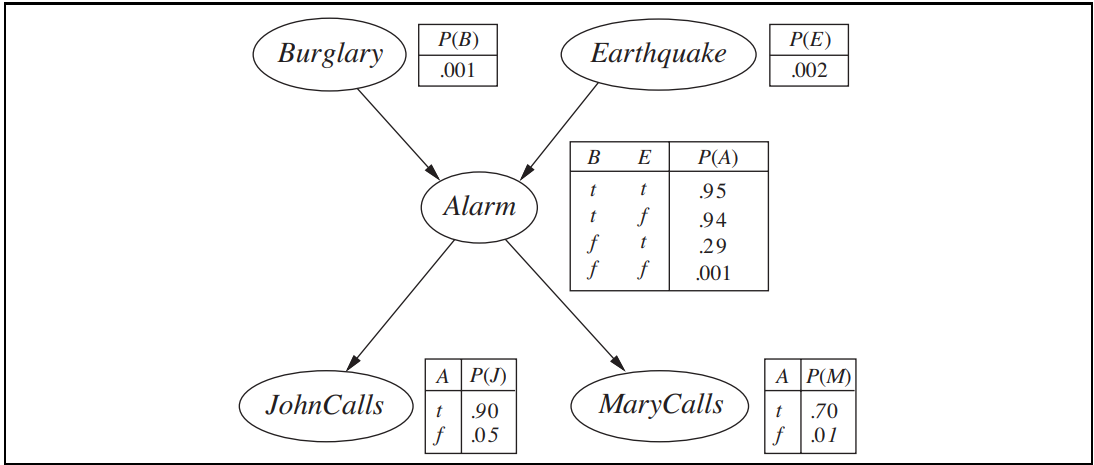

In [ ]:
#NODOS
burglary = Categorical([[0.001, 0.999]])  # Buglary  [T , F]
earthquake = Categorical([[0.002,0.998]]) # Earyhquake [T , F]


alarm = ConditionalCategorical([    #[Bulglary][Eartquake][P(alarm)]

    [  #Bulglary = T
        [[0.95, 0.05],     #Eartquake = T
         [0.94, 0.06] ],   #Eartquake = F
    [
        [0.29, 0.71],   #Eartquake = T
         [0.001, 0.999] #Eartquake = F
        ]]
])

JhonCalls = ConditionalCategorical([
    [ [0.9, 0.1],   #Alarm  = T
     [0.05, 0.95]]  #Alarm = F
    ])

MaryCalls = ConditionalCategorical([
    [[0.7,0.3],    #Alarm = T
     [0.01,0.99]]  #Alarm  = F
    ])


model = BayesianNetwork()
model.add_distributions([burglary,
                         earthquake,
                         alarm,
                         JhonCalls,
                         MaryCalls])


In [ ]:
#grafo de la red bayesiana
model.add_edge(burglary, alarm)
model.add_edge(earthquake, alarm)
model.add_edge(alarm, JhonCalls)
model.add_edge(alarm, MaryCalls)

In [ ]:
#A
#maginal
B = [0,1]
E = [0,1]

prob_1_psum = 0
for b in  B:
    for e in E:
        observation = [b, e, 0, 0, 0]
        probability = model.probability([observation])

        prob_1_psum += probability

print(prob_1_psum)

tensor([0.0016])


In [ ]:
#B
#marginal
J = [0,1]

sum2 = 0
for j in J:
    prob = model.probability([[0,1,0,j,0]])
    sum2 = sum2 + prob

print(sum2)

tensor([0.0007])


In [ ]:
#C
observation = torch.tensor([[1, 0, 0, 0, 0]])
mask = torch.tensor([[True, False, True, False ,False]])
X = MaskedTensor(observation, mask)
probabilities = model.predict_proba(X)
print(probabilities[3])
print(probabilities)


tensor([[0.9000, 0.1000]])
[tensor([[0., 1.]]), tensor([[0.3676, 0.6324]]), tensor([[1., 0.]]), tensor([[0.9000, 0.1000]]), tensor([[0.7000, 0.3000]])]


<ipython-input-8-2317568589>:3: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  X = MaskedTensor(observation, mask)


#EJERCICIO 2

---


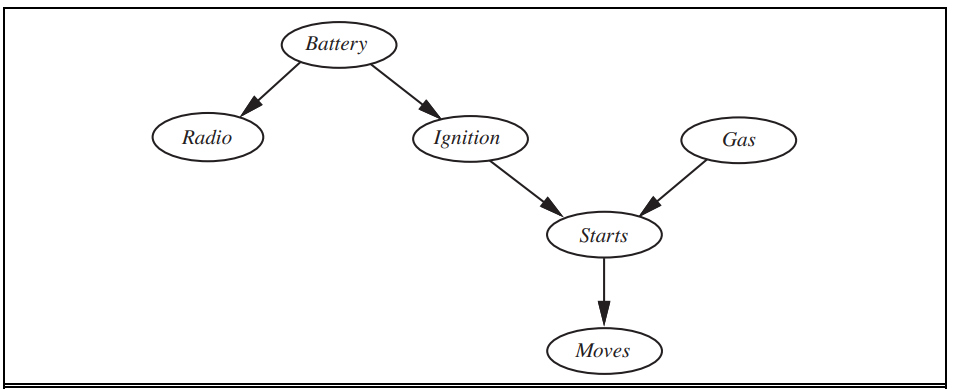

#Tablas usadas

---

### **Battery(B)**
| Estado | P(B) |
|--------|------|
| Valor  | 0.7  |

#### **Gas(G)**
| Estado | P(G) |
|--------|------|
| Valor  | 0.85 |

#### **Radio(R)**
| B  | P(R) |
|----|------|
| T  | 0.8  |
| F  | 0.05 |

#### **ignicion(I)**
| B  | P(I)   |
|----|--------|
| T  | 0.7    |
| F  | 0.1    |

#### **start(S)**
| I  | G  | P(S) |
|----|----|------|
| T  | T  | 0.9  |
| T  | F  | 0.001|
| F  | T  | 0.02 |
| F  | F  | 0.0  |

#### **Move(M)**
| S  | P(M) |
|----|------|
| T  | 0.95 |
| F  | 0.0  |

In [ ]:
#ejercicio 2
B = Categorical([
    [0.7,0.3]  # Battery: [T, F]
])

G = Categorical([
    [0.85,0.15]  # Gas: [T, F]
])

R = ConditionalCategorical([
    [[0.8,0.2],    # B=T:
     [0.05,0.95]]  # B=F
])

I = ConditionalCategorical([
    [[0.7,0.3],   # B=T
     [0.1,0.9]]   # B=F
])

S = ConditionalCategorical([              #[I][G][P(S)]
    [[  # I=T
        [0.90, 0.1],   # G=T
        [0.001, 0.999]  # G=F
    ],
    [  # I=F
        [0.02, 0.98],  # G=T
        [0.0, 1.0]      # G=F
    ]]
])

M = ConditionalCategorical([
    [[0.95,0.05],  # S=T
     [0,1]]        # S=F
])

model_4 = BayesianNetwork()   #el orden importa!!
model_4.add_distributions([B,  #battery
                           G,  #gas
                           R,  #radio
                           I,  #ignisiciacion
                           S,  #start
                           M]) #Moves
#grafo de la red el orden importa!!
model_4.add_edge(B,R)
model_4.add_edge(B,I)
model_4.add_edge(I,S)
model_4.add_edge(G,S)
model_4.add_edge(S,M)

In [ ]:
#A
observation = torch.tensor([[1, 0, 0, 0, 0, 0]])
mask = torch.tensor([[True, False, False, True, False ,False]])
X = MaskedTensor(observation, mask)
probabilities = model_4.predict_proba(X)
print(probabilities[-1])

tensor([[0.7269, 0.2731]])


<ipython-input-11-2852268143>:3: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  X = MaskedTensor(observation, mask)


In [ ]:
#B
#iterador de probabilidad marginal
B = [0,1]
M = [0,1]

#ciclo de iteracion
prob_1_psum = 0
for b in  B:
    for m in M:
        observation = [b, 0, 1, 0, 0, m]
        probability = model_4.probability([observation])

        prob_1_psum += probability

print(prob_1_psum)

tensor([0.0968])


#EJERCICIO 3

---


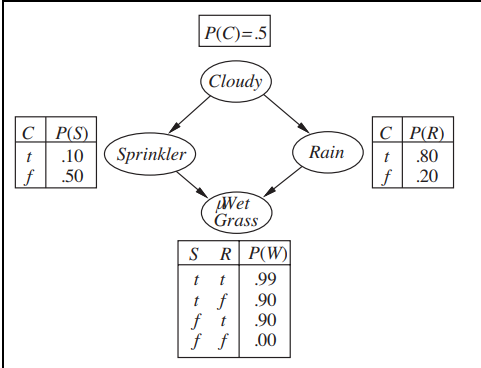

In [ ]:

C = Categorical([[0.5,0.5]])   #C [T , F]
S = ConditionalCategorical([
    [[0.10,0.90],       #C = T
    [0.5,0.5]]          #C= F
])

R = ConditionalCategorical([
    [[0.80,0.2],     #C = T
     [0.2,0.8]]      #C = F
])

W = ConditionalCategorical([  #[S][R][P(W)]

    [ #S = T
        [[0.99,0.01],  #R = T
         [0.90,0.10]   #R = F
         ],
    [ #S = F
        [0.90,0.1],   #R = T
         [0,1]]       #R = F
        ]
])

model_3 =  BayesianNetwork()
model_3.add_distributions([C, #Cloudy
                           S, #Sprinkler
                           R, #Rain
                           W  #WetGrass
                           ])
model_3.add_edge(C,S)
model_3.add_edge(C,R)
model_3.add_edge(S,W)
model_3.add_edge(R,W)

In [ ]:
#metodo convencional
#consulta de probabilidad condicional
bservation = torch.tensor([[0, 0, 0, 0]])
mask = torch.tensor([[False, True, False, True ]])

X = MaskedTensor(observation, mask)

probabilities = model_3.predict_proba(X)
print(probabilities[2])

tensor([[0.3204, 0.6796]])


<ipython-input-13-3267453543>:3: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  X = MaskedTensor(observation, mask)


In [ ]:
#sampleo
N = 10000
data = []

# simulamos 10k veces
for i in range(N):
    # sample genera un tensor con una muestra aleatoria
    sample = model_3.sample(1)

    #ESTE CONDIONAL TOMA LOS VALORES DE LA MUESTRA
    if sample[:, 1] == 0  and sample[:,-1] == 0:  # S = TRUE  Y W = TRUE
        data.append(sample[:,2].item())  # Guardo el valor de R.

# conteo de kas veces de aparicion
count = Counter(data)
prob_attend = count[0] / sum(count.values())
print('CONTEO R POR SAMPLEO:',count)
pro_0 = count[0] / sum(count.values())
pro_1 = count[1] / sum(count.values())

print(f'DISTRIBUCION DE PROBABILIDAD: 0:{pro_0}  1:{pro_1}')


CONTEO R POR SAMPLEO: Counter({1: 1908, 0: 892})
DISTRIBUCION DE PROBABILIDAD: 0:0.31857142857142856  1:0.6814285714285714


# EJECICIO 4

Las cadenas de Markov juegan un papel importante en la búsqueda online.

“PageRank es un algoritmo utilizado por la Búsqueda de Google para clasificar los sitios web en los
resultados de sus motores de búsqueda.

PageRank lleva el nombre de Larry Page, uno de los
fundadores de Google. PageRank es una forma de medir la importancia de las páginas de un sitio web
La teoría detrás del PageRank es que las páginas a las que se vincula con más frecuencia son más
importantes y útiles. Identificar aquellas que están vinculadas con más frecuencia sobre un tema ayuda
a identificar las páginas que deben presentarse como más relevantes en una búsqueda. En la búsqueda
en el mundo real, hay miles o millones de páginas que se vinculan entre sí, lo que da lugar a enormes
matrices de transición. Debido al tamaño y otras propiedades de estas matrices, las matemáticas detrás
del PageRank son más sofisticadas que el pequeño ejemplo que examinamos aquí con sólo cuatro sitios
web.
Sin embargo, nuestro ejemplo es adecuado para transmitir el concepto principal de PageRank y su uso
en algoritmos de búsqueda
Supongamos que tenemos 4 páginas web que contienen enlaces entre sí. Llamamos a las páginas A, B,
C, D.
*   Desde la página A, el 30% de las personas se vincula a la página B, el 50% se vincula a la página C
y el 20% se vincula a la página D.
*  Desde la página B, el 50% de las personas enlazan a la página A y el 50% enlazan a la página D
*  Desde la página C, el 10% de las personas se vincula a la página B, el 70% se vincula a la página C
y el 20% se vincula a la página D.
*  Desde la página D, el 20% de las personas se vincula a la página A, el 40% a la página B, el 10% a
la página C y el 30% se vincula a la página D.
(En este ejemplo, cuando una página se vincula a sí misma, significa que una persona que ve la página
permanece en esa página y no se vincula a otra página).

Construya la matriz de transición y simule cómo sería la secuencia de visita de las páginas de 5
usuarios diferentes durante 10 “pasos”.

In [ ]:
paginas = ['A','B','C','D']

#MATRIX DE TRANSICION

MATRIX_T = [
     # A    B    C    D
    [0.0, 0.3, 0.5, 0.2],  # A
    [0.5, 0.0, 0.0, 0.5],  # B
    [0.0, 0.1, 0.7, 0.2],  # C
    [0.2, 0.4, 0.1, 0.3]   # D
]




for usuario in range(5):
    visitadas = list()                                #REGISTRO DE PAGINAS VISITADAS
    pagina_visita = str(np.random.choice(paginas))    #seleccion de paginas incial de forma aleatoria

    for visit in range(10):                          #visita de 10 paginas efctuada por el ususario
        visitadas.append(pagina_visita)              #agregamos la inicial y las siguientes
        INDEX = paginas.index(pagina_visita)         #indexamos para saber cual fue y asi acceder a la matris de trancision

        pagina_visita = str(np.random.choice(paginas, p= MATRIX_T[INDEX]))  #con las probabiliades de el INDEX seleccionamos la siguiente visita

    print(f'usuario {usuario + 1}: orden de visita  {visitadas}')          #mostramos




usuario 1: orden de visita  ['C', 'D', 'A', 'C', 'C', 'C', 'B', 'A', 'C', 'C']
usuario 2: orden de visita  ['D', 'B', 'D', 'B', 'D', 'D', 'B', 'D', 'B', 'D']
usuario 3: orden de visita  ['D', 'D', 'B', 'D', 'B', 'D', 'C', 'D', 'D', 'D']
usuario 4: orden de visita  ['C', 'C', 'D', 'B', 'A', 'B', 'A', 'C', 'C', 'C']
usuario 5: orden de visita  ['B', 'A', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']


#EJERCICIO 5

---

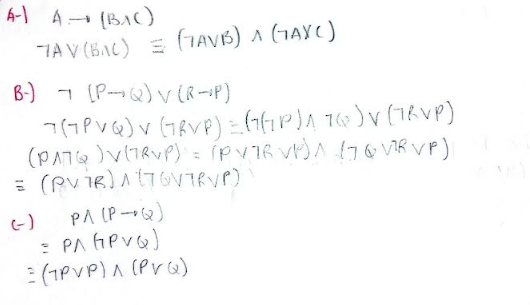


#EJERCICIO 6
---
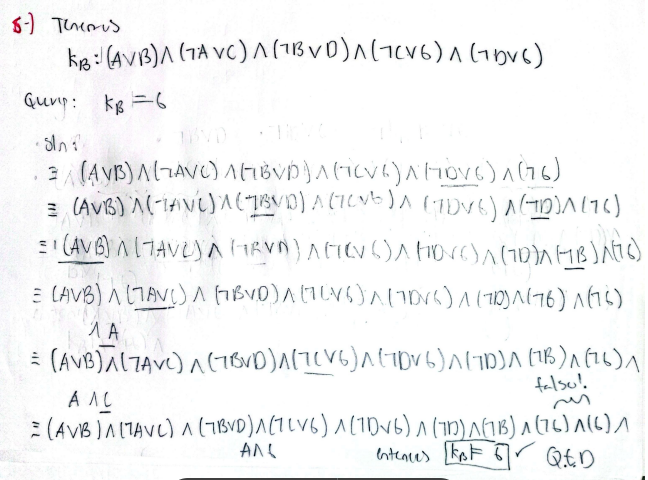

# EJERCICIO 7
---
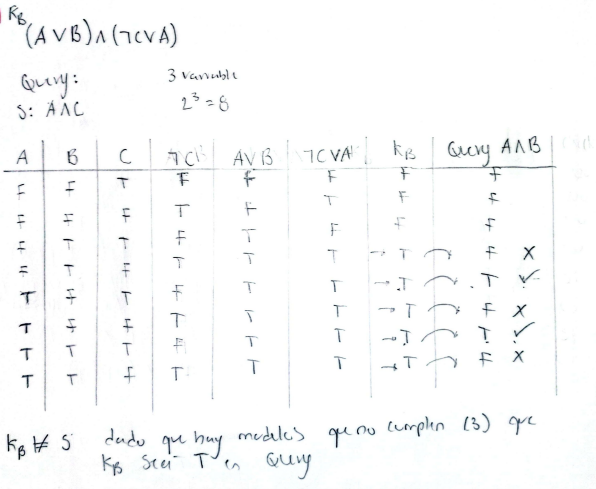

In [ ]:
#ejercicio 7


#definicion de simbolos
A = Symbol('A')
B = Symbol('B')
C = Symbol('C')

symbols = [A,B,C]

#base conocimiento segun la notacion de la libreria
knowledge = And()
knowledge.add(Or(A,B))
knowledge.add(Or(Not(C),A))
#formula
knowledge.formula()

'(A ∨  B) ∧ ((¬C) ∨  A)'

In [ ]:
#simulacion
model_check(knowledge, And(A,C))

False